Taken from the Qiskit notebook for Deutsch-Jozsa

# Deutsch-Jozsa algorithm (generalized)

In [1]:
# initialization
import numpy as np
import pandas as pd
from datetime import datetime
from depolar import depolarizing_channel
from tqdm.notebook import tqdm
from scipy.optimize import curve_fit
import matplotlib.ticker as mtick

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, execute

# import basic plot tools
from qiskit.visualization import plot_histogram
from matplotlib import pyplot as plt

In [2]:
def dj_oracle(case, n, return_bstr=False):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    if (return_bstr): return oracle_gate, b_str
    else: return oracle_gate

def dj_algorithm(oracle, n,decoherence_percent):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    depolarizing_channel(dj_circuit,n,decoherence_percent)
    dj_circuit.h(n)
    depolarizing_channel(dj_circuit,n,decoherence_percent)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
        depolarizing_channel(dj_circuit,qubit,decoherence_percent)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
        depolarizing_channel(dj_circuit,n,decoherence_percent)
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

def dj_mult(spread, n, trials):
    for i in range(trials):
        output = str(i)
        oracle_gate, oracle_func = dj_oracle(spread, n)
        output = output + ": " + str(oracle_func) + " |"
        dj_circuit = dj_algorithm(oracle_gate, n)
        results = execute(dj_circuit, backend=BasicAer.get_backend('qasm_simulator'), shots=1024).result()
        answer = results.get_counts()
        output = output + str(answer) + "\n"
        f.write(output)

The variable `decoherence_percent` is the chance that a depolarizing channel will appear after an operation, with bounds 0 <= 1. 

The variable `n` is how big the function to be checked is.

The variable `spread` is what kind of function the oracle will be. The algorithm randomly creates the oracle.

### Single Circuit

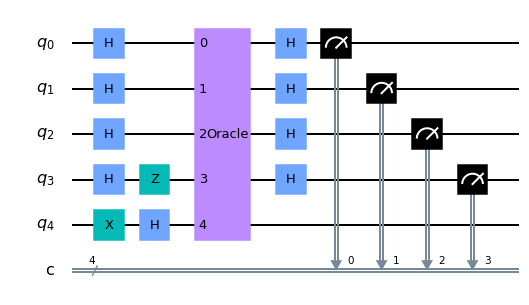

In [3]:
decoherence_percent = 0.1
n = 4
spread = 'balanced' #'balanced' or 'constant'
oracle_gate = dj_oracle(spread, n)
dj_circuit = dj_algorithm(oracle_gate, n, decoherence_percent)
dj_circuit.draw(output="mpl")

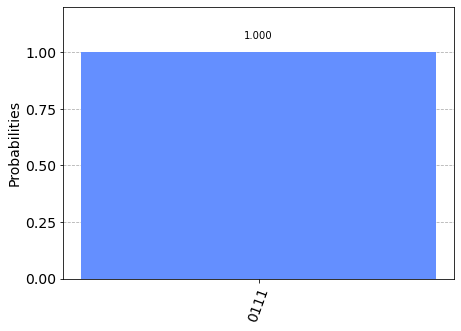

In [4]:
results = execute(dj_circuit, backend=BasicAer.get_backend('qasm_simulator'), shots=1024).result()
answer = results.get_counts()
plot_histogram(answer)

To read this result, recall the definition by Cleve et al:

> _Note that such a function is constant if a = 00...0 and balanced otherwise._

Thus, if the result is all 0, then it is **constant**; else, it is **balanced**.

## Randomizing Depolarizing Channel

For each execution, we randomize the depolarizing channel.

In [5]:
def run_dj(spread='constant', shots=100, n=4, decoherence_percent=0.1):
    oracle_gate = dj_oracle(spread, n)
    count = {}
    count['constant'] = 0
    count['balanced'] = 0
    for i in range(shots):
        dj_circuit = dj_algorithm(oracle_gate, n, decoherence_percent)
        results = execute(dj_circuit, backend=BasicAer.get_backend('qasm_simulator'), shots=1).result()
        answer = int(list(results.get_counts().keys())[0])
        
        if (answer > 0): count['balanced'] += 1
        else: count['constant'] += 1
    return count

In [6]:
run_dj(spread='balanced', shots=100, n=5)

{'constant': 5, 'balanced': 95}

Now let's run this with increasing decoherence values.

## Multiple Circuit Runs

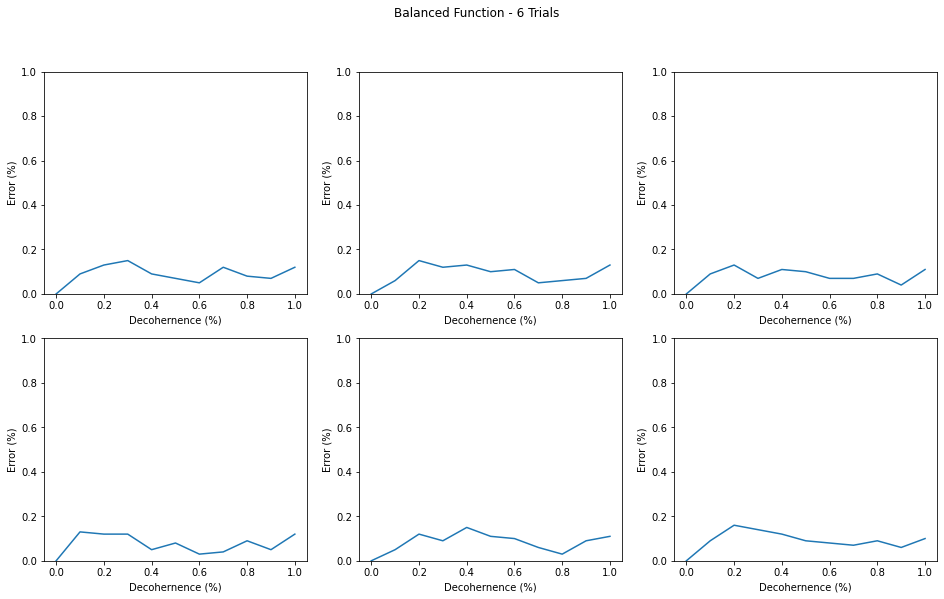

In [7]:
percentages = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
n = 4
shots=100
spread = 'balanced' #'balanced' or 'constant'
fig, axs = plt.subplots(2,3, figsize=(16,9))
fig.suptitle('Balanced Function - 6 Trials')

for element in tqdm(range(6)):
    i = int(element/3)
    j = element%3
    errors = []
    for p in percentages:
        ans = run_dj(spread=spread, shots=shots, n=n, decoherence_percent=p)
        err = (shots - ans[spread])/shots
        errors.append(err)

    axs[i,j].set_ylim([0,1])
    axs[i,j].plot(percentages, errors)
    axs[i,j].set(xlabel="Decohernence (%)", ylabel="Error (%)")

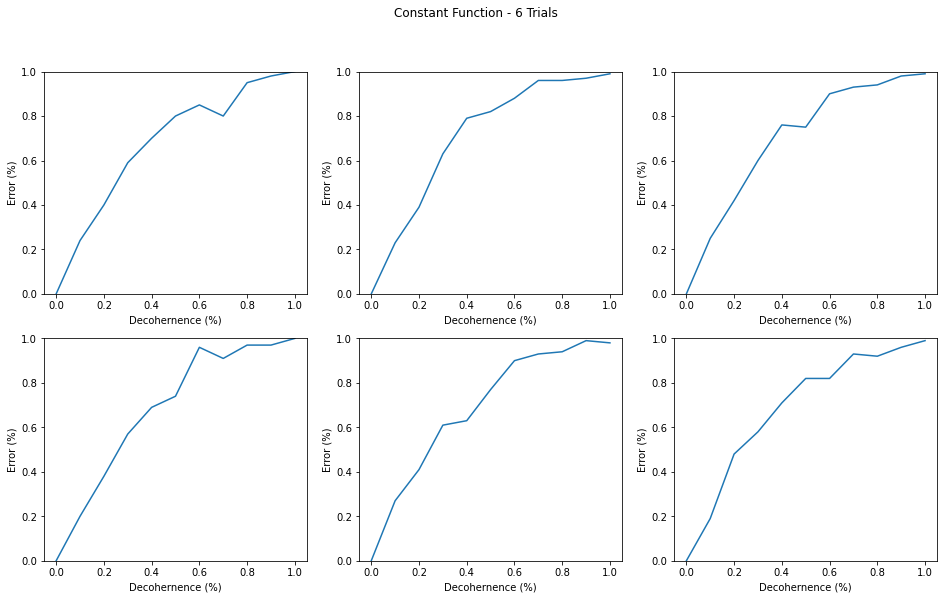

In [8]:
percentages = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
alphas = []
n = 4
shots=100
spread = 'constant' #'balanced' or 'constant'
fig, axs = plt.subplots(2,3, figsize=(16,9))
fig.suptitle('Constant Function - 6 Trials')

for element in tqdm(range(6)):
    i = int(element/3)
    j = element%3
    errors = []
    for p in percentages:
        ans = run_dj(spread=spread, shots=shots, n=n, decoherence_percent=p)
        err = (shots - ans[spread])/shots
        errors.append(err)

    axs[i,j].set_ylim([0,1])
    axs[i,j].plot(percentages, errors)
    axs[i,j].set(xlabel="Decohernence (%)", ylabel="Error (%)")

As you can see, the constant function yields a graph very similar to the one in Luigi's thesis. However, the balanced function never really shoots past 20% error. Why?

This is a result of how the Deutsch-Jozsa function is defined. In the definition of the algorithm, we assume that the given function is either _constant_ or _balanced_, and **nothing in between** (i.e. uneven number of 1's and 0's). If the function is constant, the algorithm would have an output of |0>, and if it is balanced, we would get |1>. Thus, we can set this simple rule:

> If the output of the algorithm is |0>, then the function is **constant**; else, it is **balanced**.

However, once we introduce decoherence into the system, we introduce these _"in-between"_ functions, which would eventually yield in outputs that are not all 1 or all 0 (e.g. `01100`, or `10100`). By definition of the Deutsch-Jozsa algorithm, these readings mean that the function is *balanced*.

That is why the error rates in the balanced function are so low. If we have a theoretical reading of `1111` and an actual reading of `1011`, we would still read it as balanced, so the answer would still be correct. On the other hand, if we expect a reading of `0000` but we get a reading of `0010`, we would label a constant function as balanced; hence, error.

## Intersection with Alpha

Based on the thesis, Alpha of DJ Algo = 1/3.

In [9]:
alphas = []
n = 4
shots=1
spread = 'constant' #'balanced' or 'constant'
p = float(1.0/3.0)

for i in tqdm(range(10000)):
    ans = run_dj(spread=spread, shots=shots, n=n, decoherence_percent=p)
    err = (shots - ans[spread])/shots
    alphas.append(err)
    
np.array(alphas).mean()

0.6283

In [10]:
alphas = []
n = 4
shots=1
spread = 'balanced' #'balanced' or 'constant'
p = float(1.0/3.0)

for i in tqdm(range(10000)):
    ans = run_dj(spread=spread, shots=1, n=n, decoherence_percent=p)
    err = (shots - ans[spread])/shots
    alphas.append(err)
    
np.array(alphas).mean()

0.1283

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


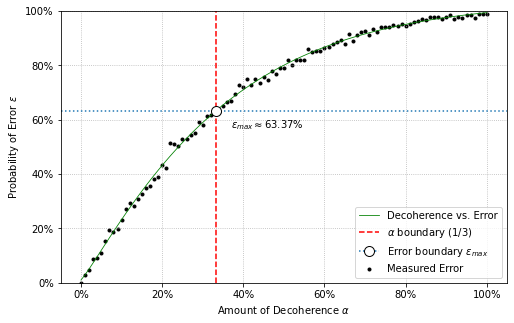

In [11]:
percentages = np.arange(0,1.001, 0.01)
alphas = []
n = 4
shots=1000
spread = 'constant' #'balanced' or 'constant'

errors = []
for p in tqdm(percentages):
    count = 0
    tot = 0
    for s in range(shots):
        ans = run_dj(spread=spread, shots=1, n=n, decoherence_percent=p)
        err = (1 - ans[spread])
        count += 1
        tot += err
    errors.append(tot/count)

###
#    function taken from
#    https://stats.stackexchange.com/questions/190107/curve-fit-with-logarithmic-regression-in-python
###

def fivepl(x, a, b, c, d, g):
    return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )

pars, cov = curve_fit(f=fivepl, xdata=percentages, ydata=errors)

emax = fivepl(1.0/3.0, *pars)

plt.figure(figsize=(8,5))
plt.ylim([0,1])
plt.plot(percentages, fivepl(percentages, *pars), linewidth=0.8, color='green', label="Decoherence vs. Error")
plt.scatter(percentages, errors, marker='.', color='black', label="Measured Error")
plt.axvline(x=((1.0/3.0)), color='r', linestyle='--', label=r'$\alpha$ boundary (1/3)') 
plt.axhline(y=emax, linestyle=':')
plt.plot(
    (1.0/3.0), emax,
    marker='o', markerfacecolor='w', markeredgecolor='k', linestyle=':', markersize=10,
    label=r"Error boundary $\epsilon_{max}$"
)

plt.annotate(r"$\epsilon_{max} \approx $" + "{0:.2%}".format(emax), (0.37, 0.57))

plt.grid(True, which='both', linestyle=':')
plt.ylabel(r"Probability of Error $\epsilon$")
plt.xlabel(r"Amount of Decoherence $\alpha$")

plt.legend(loc=4)

ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.savefig(fname="error_plot_constant.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


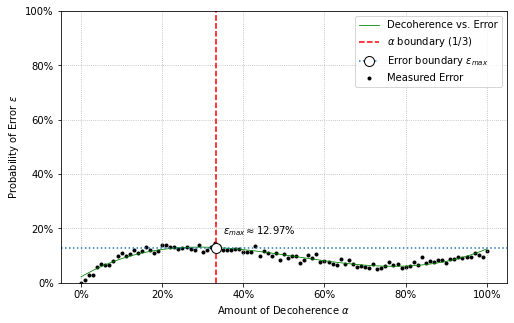

In [13]:
percentages = np.arange(0,1.001, 0.01)
n = 4
shots=1000
spread = 'balanced' #'balanced' or 'constant'

errors_balanced = []
for p in tqdm(percentages):
    count = 0
    tot = 0
    for s in range(shots):
        ans = run_dj(spread=spread, shots=1, n=n, decoherence_percent=p)
        err = (1 - ans[spread])
        count += 1
        tot += err
    errors_balanced.append(tot/count)

def f(x, a, b, c, d):
    return (a * x*x*x) + (b*x*x) + (c*x) + d

pars, cov = curve_fit(f, percentages, errors_balanced)

emax = f(1.0/3.0, *pars)

plt.figure(figsize=(8,5))
plt.ylim([0,1])
plt.plot(percentages, f(percentages, *pars), linewidth=0.8, color='green', label="Decoherence vs. Error")
plt.scatter(percentages, errors_balanced, marker='.', color='black', label="Measured Error")
plt.axvline(x=((1.0/3.0)), color='r', linestyle='--', label=r'$\alpha$ boundary (1/3)') 
plt.axhline(y=emax, linestyle=':')
plt.plot(
    (1.0/3.0), emax,
    marker='o', markerfacecolor='w', markeredgecolor='k', linestyle=':', markersize=10,
    label=r"Error boundary $\epsilon_{max}$"
)

plt.annotate(r"$\epsilon_{max} \approx $" + "{0:.2%}".format(emax), (0.35, 0.18))

plt.grid(True, which='both', linestyle=':')
plt.ylabel(r"Probability of Error $\epsilon$")
plt.xlabel(r"Amount of Decoherence $\alpha$")

plt.legend()

ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.savefig(fname="error_plot_balanced.eps")